# Detección de peatones
[Daimler Mono Ped. Classification Benchmark Data Set](http://www.gavrila.net/Datasets/Daimler_Pedestrian_Benchmark_D/Daimler_Mono_Ped__Class__Bench/daimler_mono_ped__class__bench.html)

In [4]:
import os
from os import path
import random

import numpy as np
from PIL import Image


class PedestrianDataset:
    classes: list[str] = []
    def __init__(self, dataset_dir: str, shuffle: bool = True):
        self.__images: list[str] = []
        self.__labels: list[str] = []
        dir_abs_route = path.abspath(dataset_dir)
        for item in os.listdir(dir_abs_route):
            subdirectory = path.join(dir_abs_route, item)
            if path.isdir(subdirectory):
                new_images = self.__get_directory_files(subdirectory)
                self.__images += new_images
                if item not in self.classes:
                    self.classes.append(item)
                class_id = self.classes.index(item)
                self.__labels += list([class_id for _ in range(len(new_images))])
        if shuffle:
            aux = list(zip(self.__images, self.__labels))
            random.shuffle(aux)
            self.__images, self.__labels = zip(*aux)

    def __getitem__(self, index: int) -> tuple[np.ndarray, int]:
        with Image.open(self.__images[index]) as image:
            image_array = np.array(image)
        label = self.__labels[index]
        return image_array, label

    def __len__(self) -> int:
        return len(self.__images)

    def __get_directory_files(self, directory: str) -> list[str]:
        """Returns a list containing the absolute path to each file inside the directory
        """
        file_paths = []
        files = os.listdir(directory)
        for file in files:
            abs_filename = path.join(directory, file)
            file_paths.append(abs_filename)
        return sorted(file_paths)

ped_examples


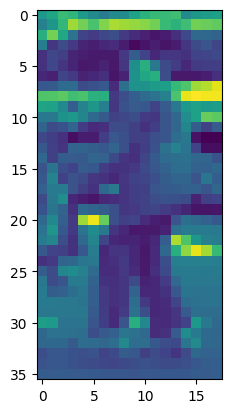

In [5]:
import matplotlib.pyplot as plt


train_dataset = PedestrianDataset("data/1")
test_dataset = PedestrianDataset("data/T1")
image, label = train_dataset[0]
print(train_dataset.classes[label])
plt.imshow(image)
plt.show()

In [3]:
from skimage.feature import hog


def compute_hog_features(dataset: PedestrianDataset) -> tuple[list, list]:
    features = []
    labels = []
    for image, label in dataset:
        hog_feature = hog(image, orientations=11, pixels_per_cell=(4, 4), cells_per_block=(2, 2),
                          transform_sqrt=False, feature_vector=True)
        features.append(hog_feature)
        labels.append(label)
    return features, labels


In [4]:
train_features, train_labels = compute_hog_features(train_dataset)
test_features, test_labels = compute_hog_features(test_dataset)

In [5]:
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.001, 0.0001]}
grid_search = GridSearchCV(SVC(), param_grid, n_jobs=5)
grid_search.fit(train_features, train_labels)
predictions = grid_search.predict(test_features)
conf_matrix = metrics.confusion_matrix(test_labels, predictions)
print(grid_search.best_params_)
print(metrics.classification_report(test_labels, predictions))

{'C': 10, 'gamma': 0.1}
                  precision    recall  f1-score   support

non-ped_examples       0.69      0.95      0.80      5000
    ped_examples       0.91      0.56      0.70      4800

        accuracy                           0.76      9800
       macro avg       0.80      0.76      0.75      9800
    weighted avg       0.80      0.76      0.75      9800



                  precision    recall  f1-score   support

non-ped_examples       0.69      0.95      0.80      5000
    ped_examples       0.91      0.56      0.70      4800

        accuracy                           0.76      9800
       macro avg       0.80      0.76      0.75      9800
    weighted avg       0.80      0.76      0.75      9800



<Axes: >

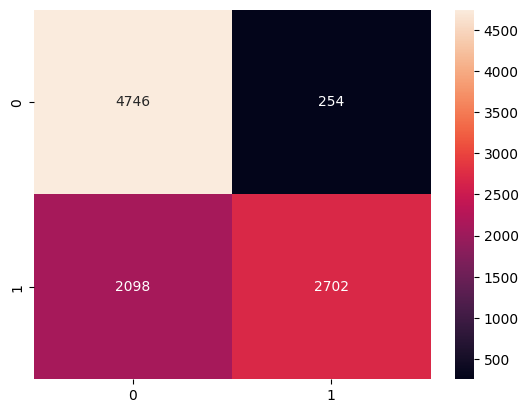

In [6]:
pedestrian_detector = SVC(C=10, gamma=0.1)
pedestrian_detector.fit(train_features, train_labels)
predictions = pedestrian_detector.predict(test_features)
conf_matrix = metrics.confusion_matrix(test_labels, predictions)
print(metrics.classification_report(test_labels, predictions))
sns.heatmap(conf_matrix, annot=True, fmt="d")

## Histogram of Oriented Gradients vs CNN

In [12]:
import torch
from torch import Tensor
from torch.utils.data import Dataset
import torchvision.transforms.v2.functional as F


class TorchPedestrianDataset(Dataset):
    def __init__(self, dataset: PedestrianDataset):
        self.__dataset: PedestrianDataset = dataset

    def __getitem__(self, index: int) -> tuple[Tensor, int]:
        img, label = self.__dataset[index]
        image: Tensor = torch.from_numpy(img)
        image = image.unsqueeze(0)
        image = image.float()
        image = image / 255
        image = F.resize(image, [224, 224])
        return image, label

    def __len__(self) -> int:
        return len(self.__dataset)

In [13]:
from torch.utils import data
from torch.utils.data import DataLoader


BATCH_SIZE = 32
TRAIN_PERCENTAGE = 0.8

dataset = TorchPedestrianDataset(train_dataset)
trainset, validationset = data.random_split(dataset, [TRAIN_PERCENTAGE, 1-TRAIN_PERCENTAGE])
train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
validation_loader = DataLoader(validationset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
testset = TorchPedestrianDataset(test_dataset)

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [15]:
from torch.nn import Conv2d, Linear, Sequential, Softmax
from torchvision.models import resnet
from torchvision.models.resnet import ResNet, ResNet50_Weights


def load_resnet_50(num_classes, num_channels) -> ResNet:
    model = resnet.resnet50(weights= ResNet50_Weights.IMAGENET1K_V2)
    model.conv1 = Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = Sequential(
        Linear(model.fc.in_features, num_classes),
        Softmax(1))
    return model


classifier = load_resnet_50(2, 1)
classifier = classifier.to(device)

In [16]:
def print_loss_history(train_loss: list[float], val_loss: list[float]):
    epochs = range(1, len(train_loss) + 1)
    plt.figure(figsize=(10, 8), )
    plt.plot(epochs, train_loss, "bo", label="Training loss")
    plt.plot(epochs, val_loss, "b--", label="Validation loss")
    plt.title("Training loss")
    plt.legend()
    plt.grid()
    plt.show()

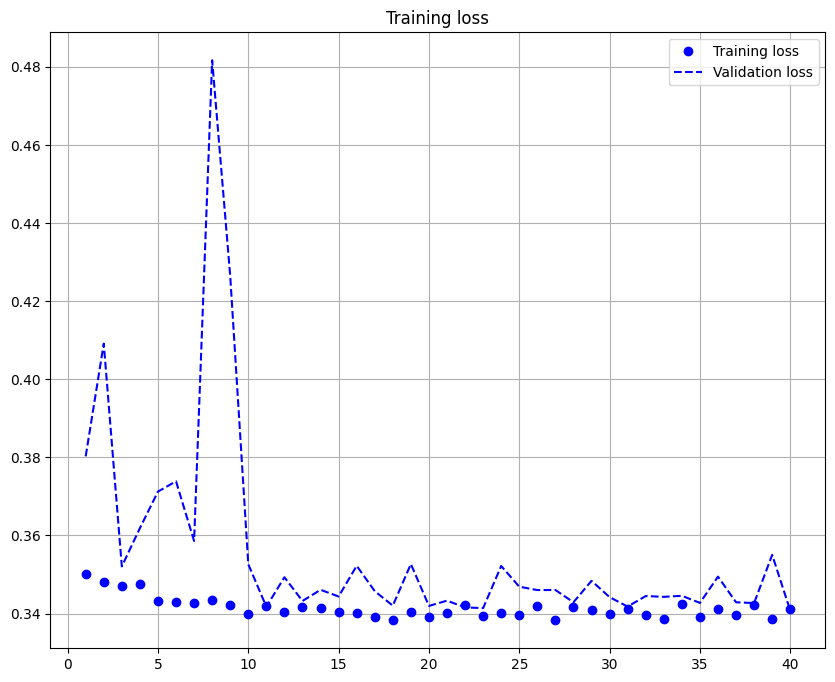

In [29]:
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau


LEARNING_RATE = 0.0005
EPOCHS = 40
WEIGHT_DECAY = 0.001


criterion = CrossEntropyLoss()
optimizer = SGD(classifier.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = ReduceLROnPlateau(optimizer, patience=5)
train_loss = []
validation_loss = []
for epoch in range(1, EPOCHS + 1):
    running_loss = 0
    classifier.train()
    for i, data in enumerate(train_loader):
        images, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = classifier(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    val_loss = 0
    classifier.eval()
    with torch.no_grad():
        for i, data in enumerate(validation_loader):
            images, labels = data[0].to(device), data[1].to(device)
            outputs = classifier(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss = val_loss / len(validation_loader)
    epoch_loss = running_loss / len(train_loader)
    train_loss.append(epoch_loss)
    validation_loss.append(val_loss)
    scheduler.step(val_loss)
print_loss_history(train_loss, validation_loss)

Accuracy: 0.78551
              precision    recall  f1-score   support

           0       0.89      0.64      0.75      4800
           1       0.73      0.92      0.81      5000

    accuracy                           0.79      9800
   macro avg       0.81      0.78      0.78      9800
weighted avg       0.81      0.79      0.78      9800



<Axes: >

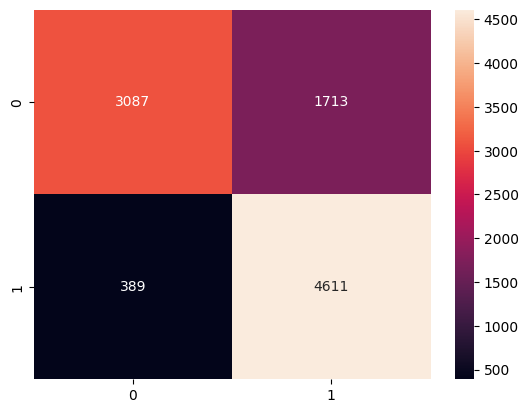

In [31]:
EPOCHS = 22


cnn_classifier = load_resnet_50(2, 1)
cnn_classifier = cnn_classifier.to(device)
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
criterion = CrossEntropyLoss()
optimizer = SGD(cnn_classifier.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = ReduceLROnPlateau(optimizer, patience=5)
for epoch in range(1, EPOCHS + 1):
    running_loss = 0
    cnn_classifier.train()
    for i, data in enumerate(data_loader):
        images, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = cnn_classifier(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    cnn_classifier.eval()
    epoch_loss = running_loss / len(data_loader)
    scheduler.step(epoch_loss)

predictions = []
ground_truth = []
cnn_classifier.eval()
with torch.no_grad():
    for data in testset:
        image, label = data[0].unsqueeze(0).to(device), data[1]
        prediction = cnn_classifier(image).cpu()
        predicted_class = torch.max(prediction, 1).indices.item()
        predictions.append(predicted_class)
        ground_truth.append(label)
conf_matrix = metrics.confusion_matrix(ground_truth, predictions)
print(f"Accuracy: {metrics.accuracy_score(ground_truth, predictions):.5f}")
print(metrics.classification_report(ground_truth, predictions))
sns.heatmap(conf_matrix, annot=True, fmt="d")